In [1]:
import numpy as np
from transformers import LayoutLMv3Processor, LayoutLMv3Tokenizer, LayoutLMv3ForTokenClassification, AdamW
from transformers import TrainingArguments, Trainer
from datasets import load_dataset, Dataset, Features, Sequence, ClassLabel, Value, Array2D, Array3D, load_metric
import torch
from PIL import Image, ImageDraw, ImageFont
from pathlib import Path
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

2023-09-01 13:16:25.932582: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 13:16:25.968166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 13:16:26.543296: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Train the model on the benchmark FUNSD Dataset

In [29]:
dataset = load_dataset("nielsr/funsd-layoutlmv3")

In [30]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None)}

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [32]:
processor = LayoutLMv3Processor.from_pretrained(
    "microsoft/layoutlmv3-base", apply_ocr = False
)

In [33]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

In [34]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [35]:
# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

In [36]:
train_dataset.set_format("torch")

In [37]:
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
metric = load_metric("seqeval")

/tmp/ipykernel_767129/152412463.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [39]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [40]:
training_args = TrainingArguments(output_dir="test",
                                  max_steps=10000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [41]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [42]:
trainer.train()

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.668126,0.761971,0.822156,0.790920,0.775585
200,No log,0.525412,0.826834,0.884749,0.854812,0.815524
300,No log,0.510223,0.865258,0.915549,0.889693,0.837632
400,No log,0.565931,0.832346,0.907601,0.868346,0.816950
500,0.533600,0.671987,0.871367,0.908594,0.889591,0.818852
600,0.533600,0.692804,0.884427,0.897168,0.890752,0.822418
700,0.533600,0.663868,0.870281,0.893194,0.881589,0.825865
800,0.533600,0.784914,0.899546,0.885246,0.892339,0.820872
900,0.533600,0.714616,0.884817,0.923497,0.903743,0.838583
1000,0.128200,0.759860,0.892996,0.912072,0.902433,0.831451


/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be rem

TrainOutput(global_step=10000, training_loss=0.03793863228559494, metrics={'train_runtime': 1604.6608, 'train_samples_per_second': 12.464, 'train_steps_per_second': 6.232, 'total_flos': 5237047353990144.0, 'train_loss': 0.03793863228559494, 'epoch': 133.33})

In [43]:
trainer.evaluate()

/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'eval_loss': 1.405912160873413,
 'eval_precision': 0.9148202855736091,
 'eval_recall': 0.9230004967709886,
 'eval_f1': 0.9188921859545004,
 'eval_accuracy': 0.847735647212647,
 'eval_runtime': 2.3618,
 'eval_samples_per_second': 21.17,
 'eval_steps_per_second': 10.585,
 'epoch': 133.33}

In [210]:
from transformers import AutoModelForTokenClassification
modelstatus = "/home/sebastian/Documents/Hauptprojekt/Information Extraction/test/checkpoint-5000"
model = AutoModelForTokenClassification.from_pretrained(modelstatus)
#model = AutoModelForTokenClassification.from_pretrained('nielsr/layoutlmv3-finetuned-funsd')
model.to(device)

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

# Inference the Model on the picture of the DocILE Dataset

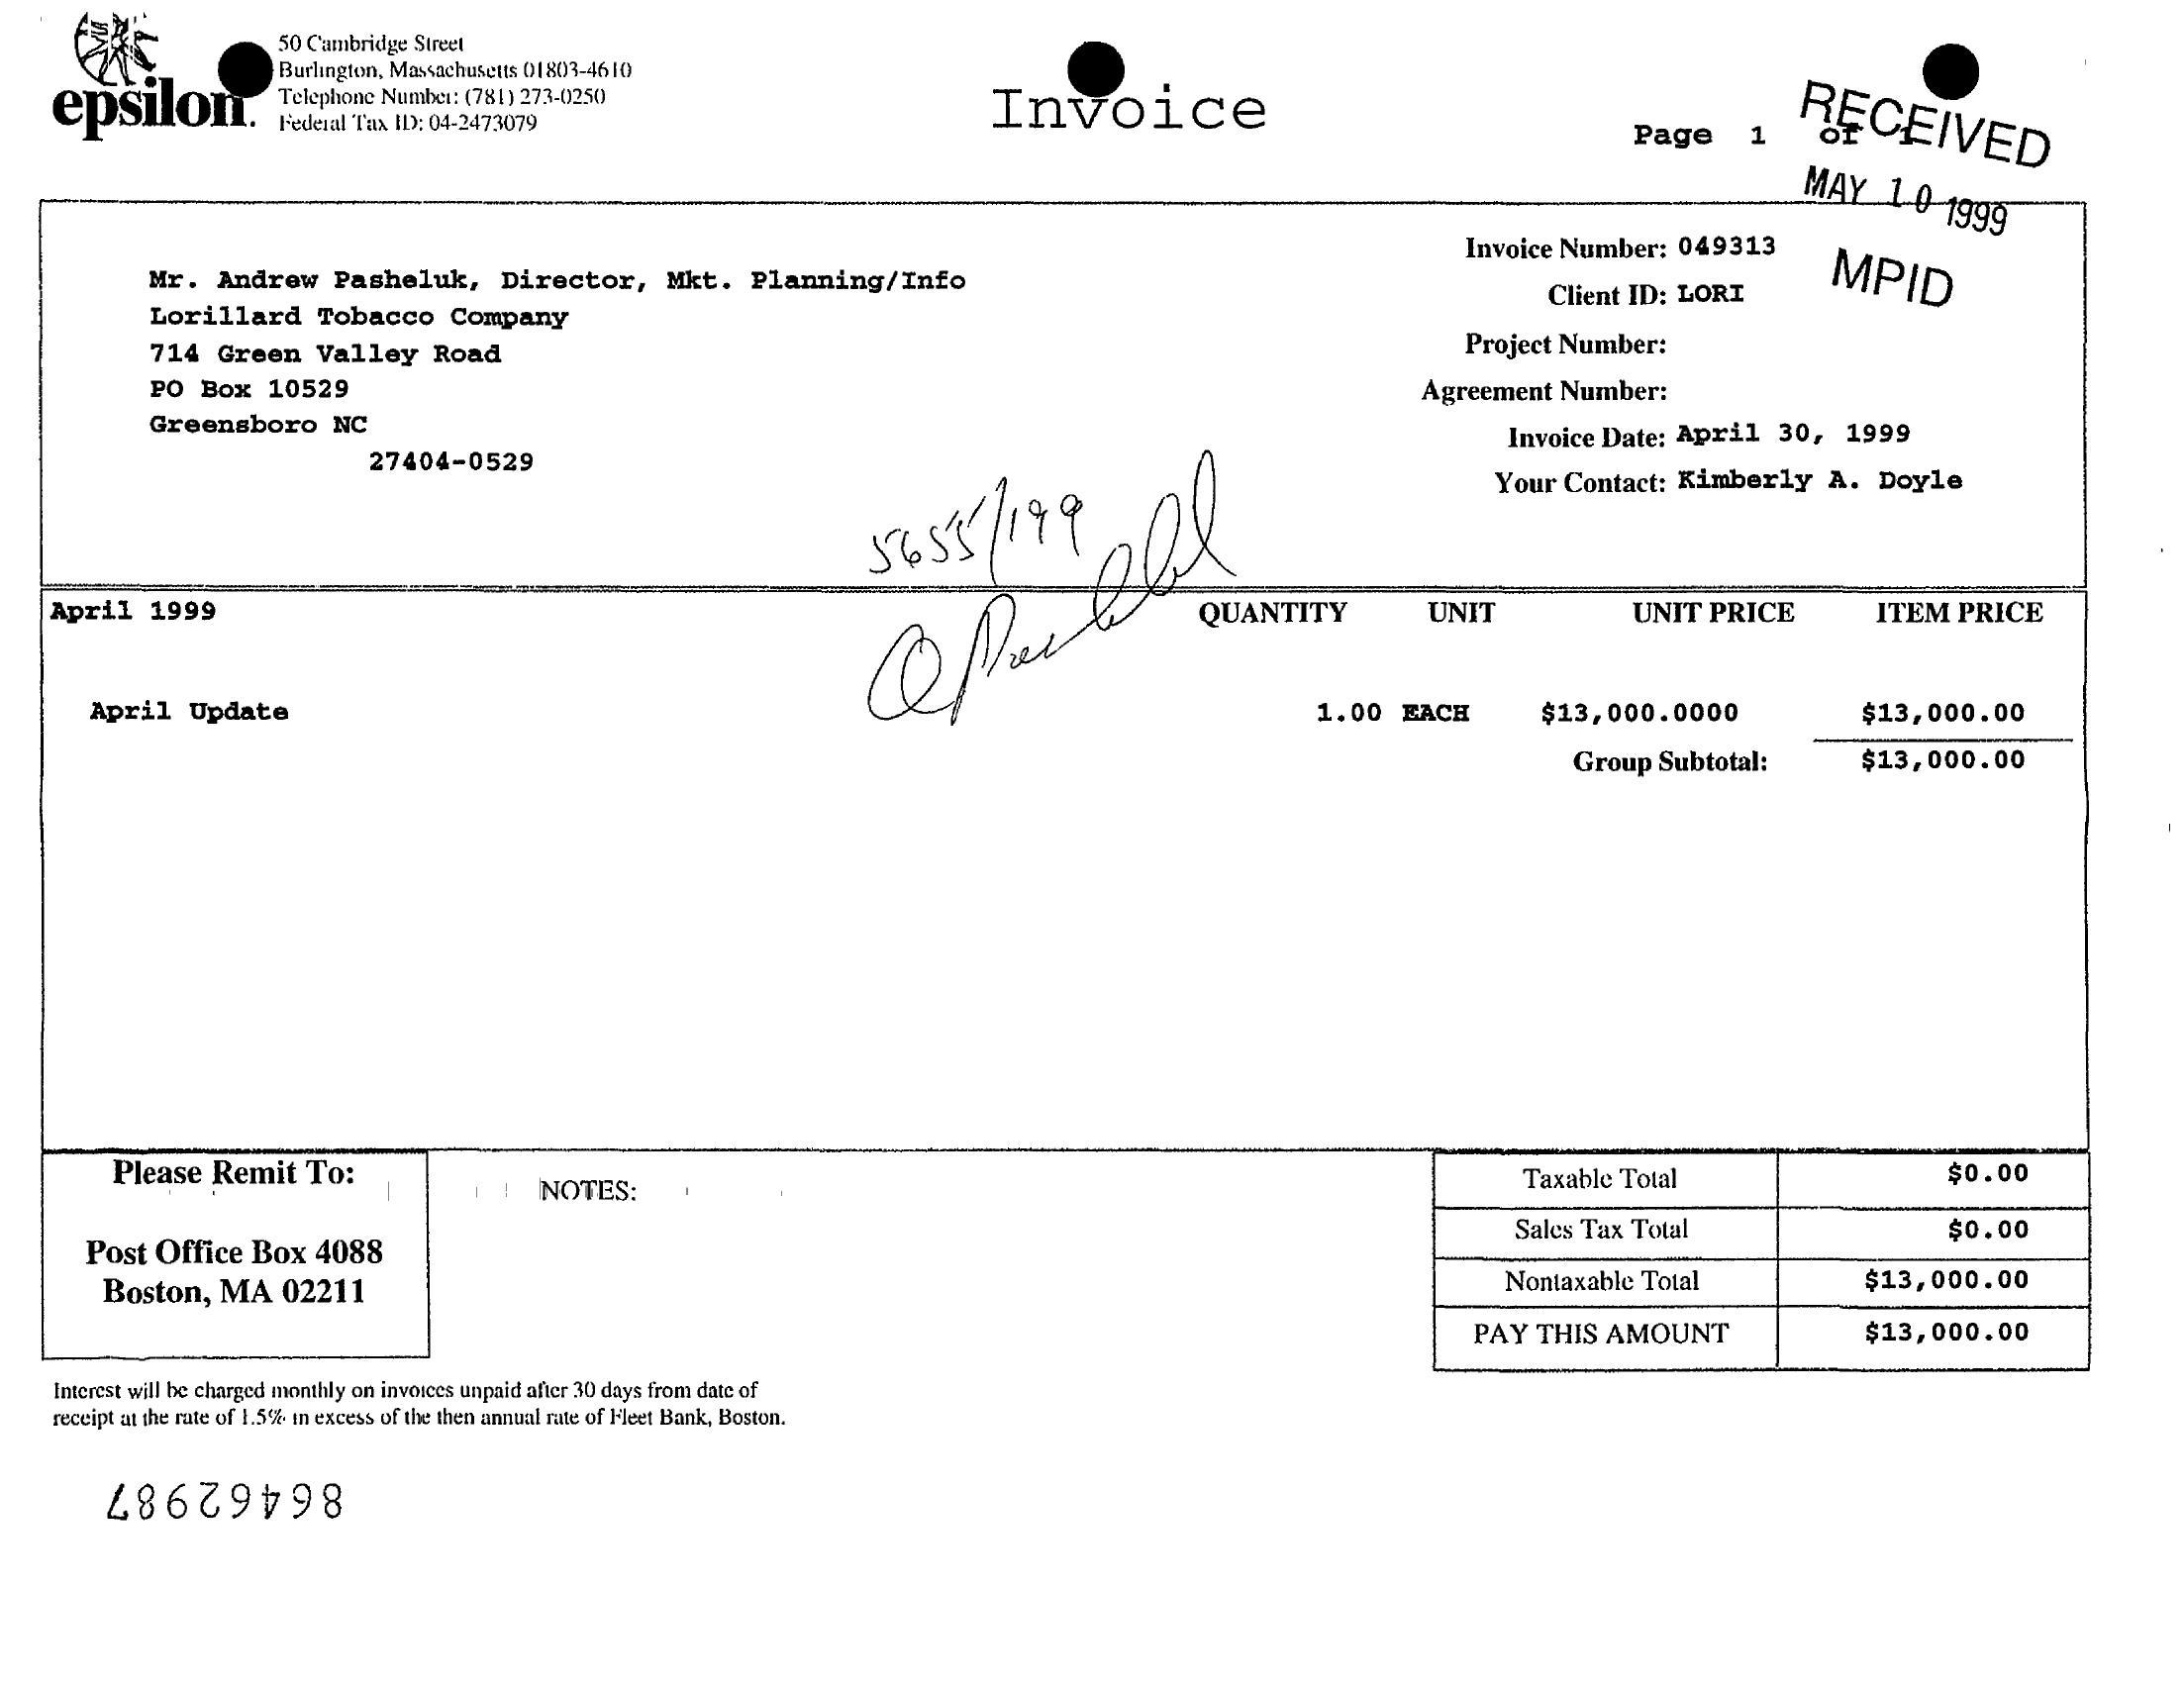

In [211]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/0a264c8a0e204ae8868ec14f(1).jpg")
image = image.convert("RGB")
image

In [212]:
processor = LayoutLMv3Processor.from_pretrained("nielsr/layoutlmv3-finetuned-funsd")

encoding = processor(image, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoding.pop('offset_mapping')
print(encoding.keys())

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'LayoutLMv3TokenizerFast'.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])


In [213]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for k,v in encoding.items():
  encoding[k] = v.to(device)

In [214]:
outputs = model(**encoding)
print(outputs.logits.shape)

torch.Size([1, 287, 7])


/home/sebastian/anaconda3/envs/pt/lib/python3.9/site-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [215]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoding.bbox.squeeze().tolist()

width, height = image.size

In [216]:
id2label = ["O", "B-HEADER", "I-HEADER", "B-QUESTION", "I-QUESTION", "B-ANSWER", "I-ANSWER"]

In [217]:
is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

In [218]:
print(true_predictions)
print(true_boxes)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-HEADER', 'O', 'B-HEADER', 'B-HEADER', 'B-HEADER', 'B-HEADER', 'B-QUESTION', 'B-QUESTION', 'O', 'O', 'B-HEADER', 'O', 'O', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'O', 'B-QUESTION', 'O', 'B-QUESTION', 'O', 'O', 'B-QUESTION', 'O', 'O', 'O', 'O', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-QUESTION', 'O', 'O', 'B-QUESTION', 'B-QUESTION', 'O', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-QUESTION', 'B-QUESTION', 'O', 'O', 'O', 'B-QUESTION', 'B-QUESTION', 'O', 'O', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-ANSWER', 'O', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'O', 'O', 'O', 'B-QUESTION', 'B-QUESTION', 'O', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-ANSWER', 'B-QUESTION', 'B-QUESTION', 'O', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTION', 'B-QUESTIO

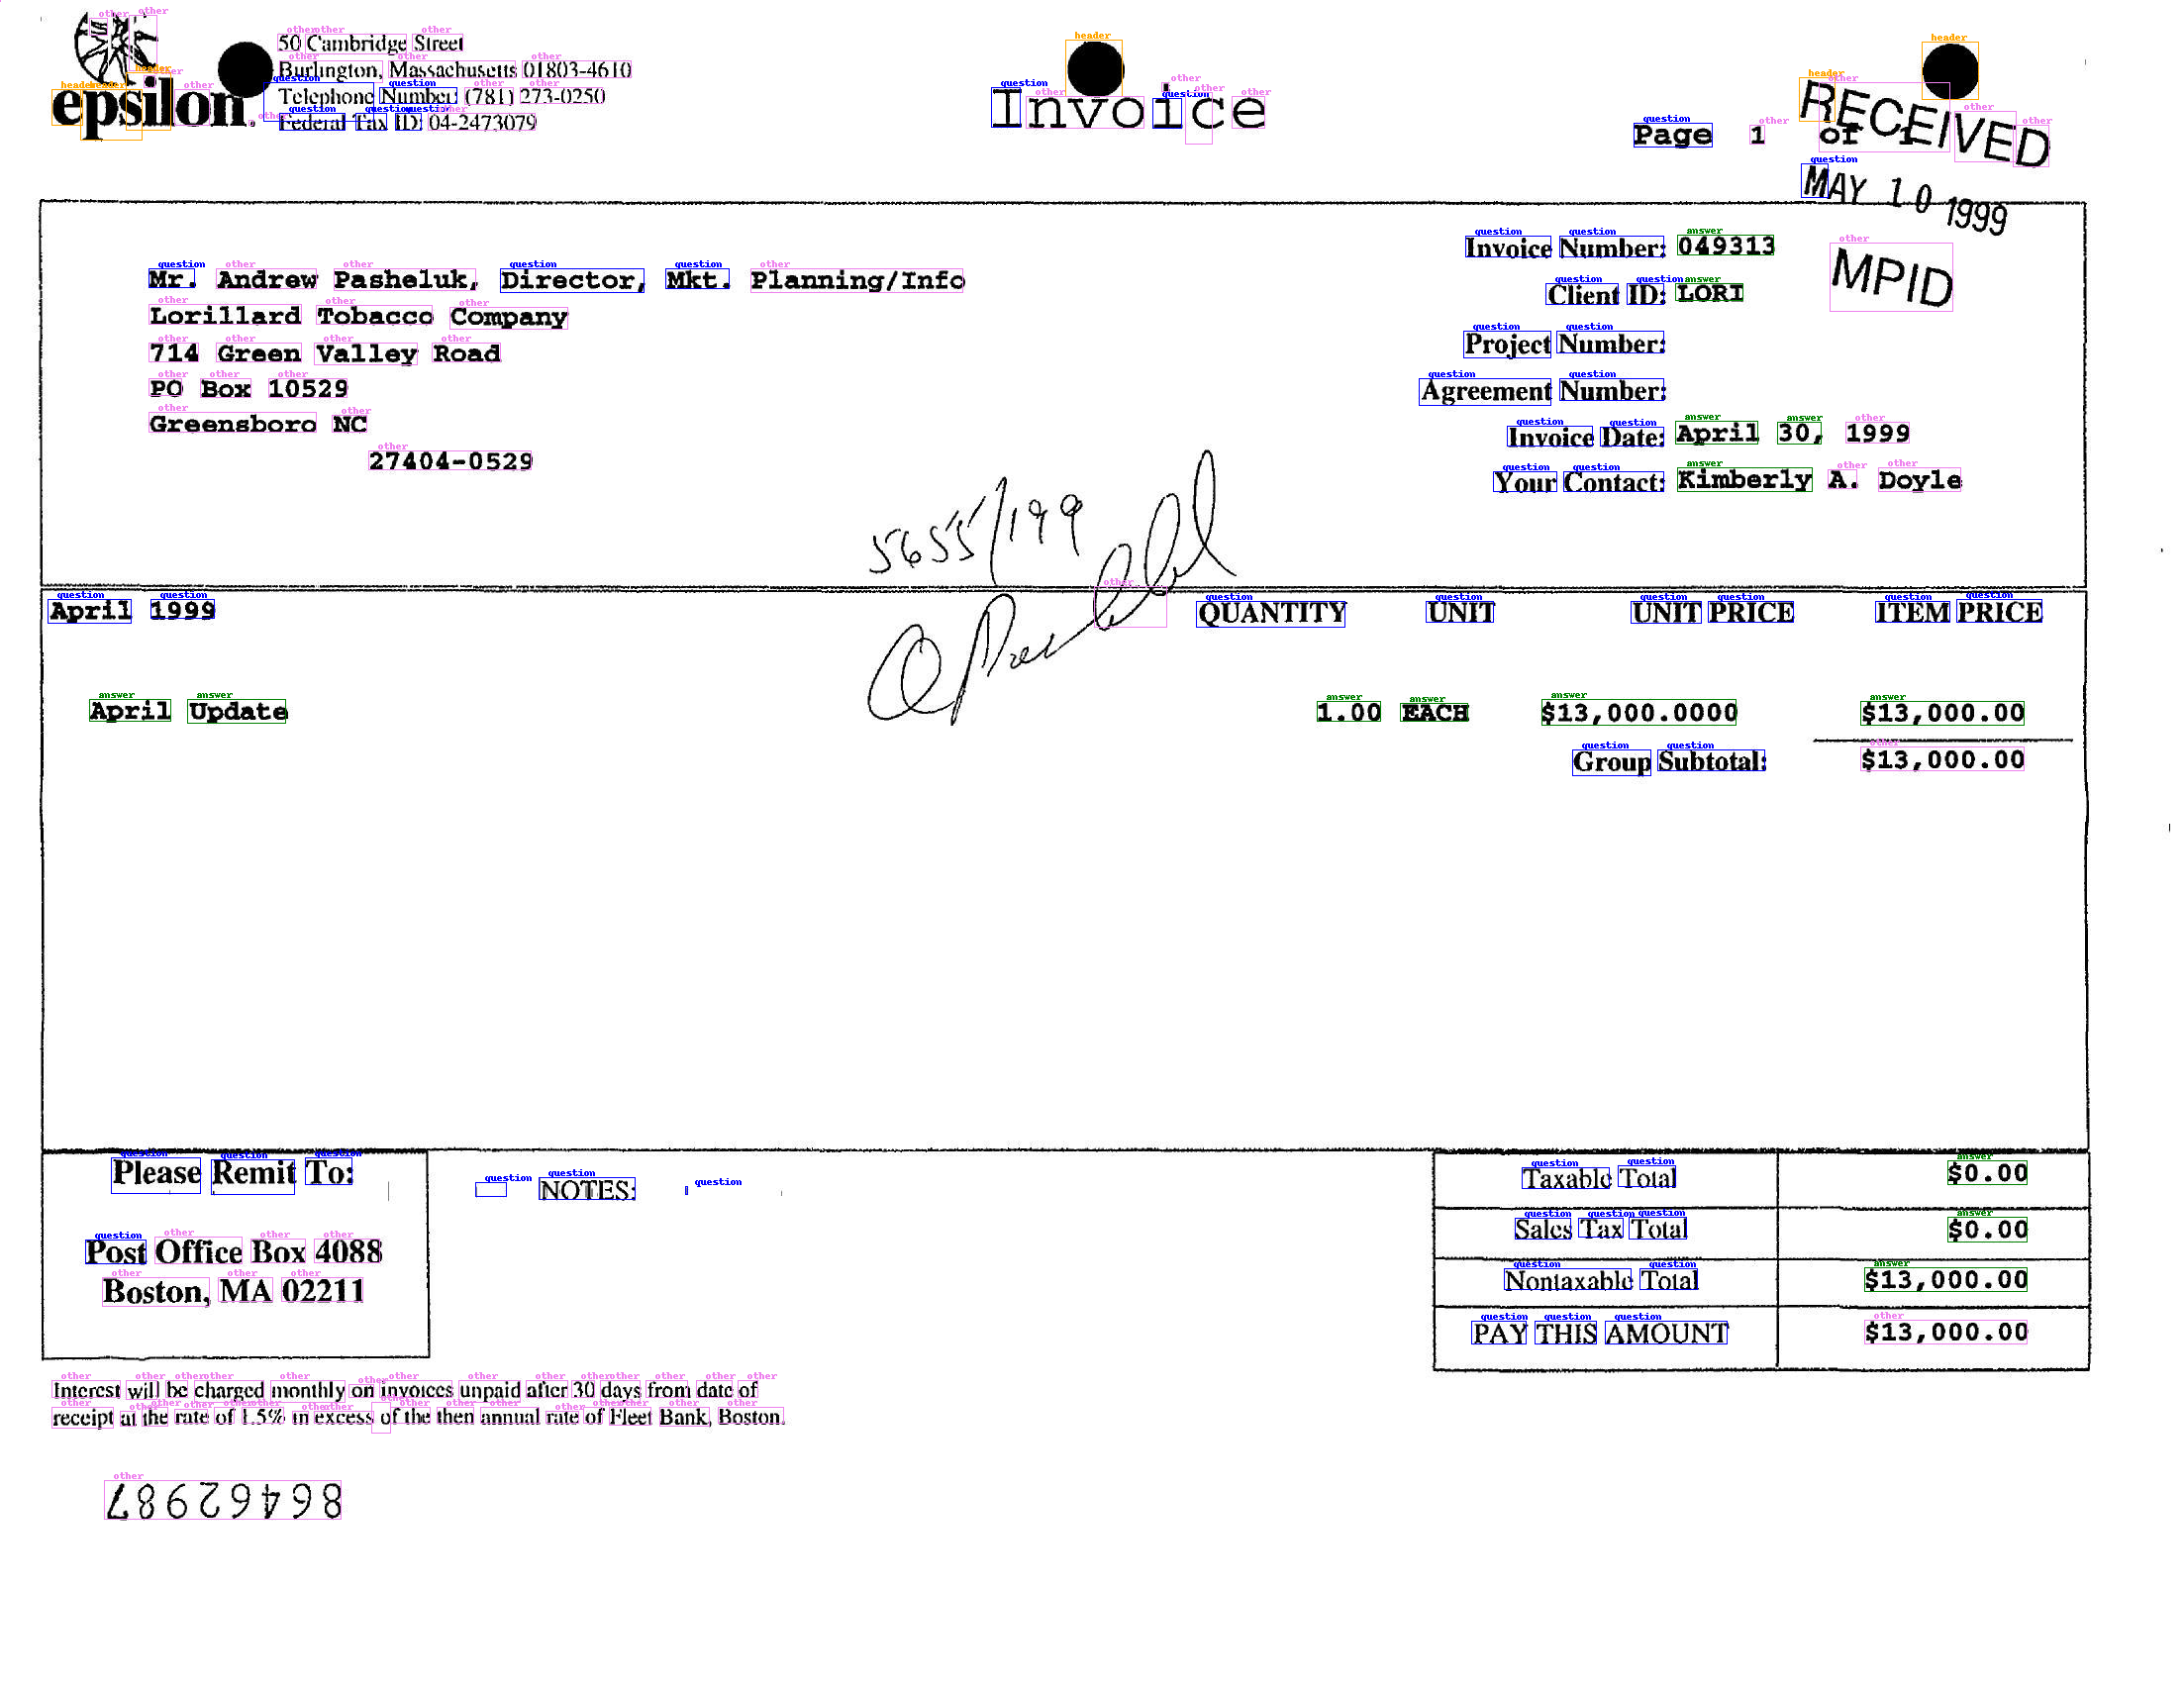

In [219]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)

image.save('/home/sebastian/Documents/Hauptprojekt/Plots/InformationExtraction/5001epochs.png')
image
     
